# Study of housing prices in Belgium, part 3: Regression analysis (OLS and Random Forests)

## Importing packages

In [1]:
# import packages

import pandas as pd
import numpy as np

# packages for prediction: OLS estimation
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
# packages for prediction: Random forest regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# vizualisation
import matplotlib.pyplot as plt
import seaborn as sns


## Importing datasets

In [2]:
# notebook settings
pd.options.display.max_columns = None
path = "C:/Users/Bedoret/OneDrive/Data Science/Housing prices in Belgium/"

# immoweb dataset
properties = pd.read_excel('{}properties_2021_08_12.xlsx'.format(path), index_col = 0)
properties2 = properties

# additional datasets on population density, income level and urbanisation rate per municipality
refnis = pd.read_excel('{}INSEE-Belgique.xlsx'.format(path))
population = pd.read_excel('{}Population_2019.xlsx'.format(path), index_col = 0)
income = pd.read_excel('{}Revenus_2018.xlsx'.format(path), index_col = 0)
price_2020 = pd.read_excel('{}Prix_median_2020.xlsx'.format(path))


# postal codes of Brussel's ans Knokke municipalities
bxl = pd.DataFrame([1000,1020,1030,1040,1050,1060,1070,1080,1081,1082,1083,1090,1140,1150,1160,1170,1180,1190,1200,1210],
                    columns={"Code postal"})
bxl["Bxl"] = 1
knokke = pd.DataFrame([8300, 8301], columns= {"Code postal"})
knokke["Knokke"] = 1

In [3]:
# merge the additional datasets with our immoweb dataset 
properties = properties.merge(refnis, on = "Code postal", how = "left" )
properties = properties.astype({"Refnis": int})

properties = properties.merge(population, on = "Refnis", how = "left")\
                         .merge(income, on = "Refnis", how = "left")\
                         .merge(price_2020, on = "Refnis", how = "left")\
                         .merge(bxl, on = "Code postal", how = "left")\
                         .merge(knokke, on = "Code postal", how = "left")
properties = properties.astype({"Code postal": int})
properties["Bxl"].fillna(0, inplace=True)
properties["Knokke"].fillna(0, inplace=True)

# extract apartments and houses datasets from our main dataset
houses = properties.loc[properties["Type"]=="HOUSE"]
apartments = properties.loc[properties["Type"]=="APARTMENT"]

## Quality check of the datasets

In [4]:
# look at the percentage of missing values for each variable in each dataset.
# Missing values may have a strong impact on the results !
# In a classic linear regression, any observration with missing values will be removed from the analysis, 
# leaving only observations for which the features are non missing. We must then ensure that removing 
# observations with any missing values will not affect the price too much. In other words we must ensure 
# that our new sample remains representative of our original dataset when these observations are removed.

def percent_missing(df):
    percent_missing = pd.DataFrame(df.isnull().mean()*100)
    percent_missing.sort_values(0, inplace = True, ascending = False)
    return percent_missing

# percent_missing(properties).join(percent_missing(houses), lsuffix = '_properties', rsuffix = '_houses')\
#                            .join(percent_missing(apartments), rsuffix = '_apartments')


In [5]:
# How does the average price per square meter change when we remove the observations for which we observe missing values?.
# If the difference is large, it implies that missing values in that variable have an impact on the average price.
# Hence we might prefer to withdraw these variables from our analysis, as they might bias the overall price average.

def price_diff(df, var):
    """
    computes the average price per square meter of the total 
    data frame (df) versus the average price per square meter when 
    missing values of 'var' are removed.
    returns:
    'avg1': the average price the full dataset
    'avg2': the average price of the dataset without the observation whith missing values in var.
    """
    avg1 = int(df['Prix'].mean())
    avg2 = int(df[(var.notna())]['Prix'].mean())
    return  print("all data:     ",avg1,"\nna's removed: ", avg2,"\ndiff:         ", avg1-avg2)


# example: removing observations with missing values in "garden size" increases the average price per sq meter by 133€.
#price_diff(houses, houses["Surface du jardin"])

## Define the OLS and Random Forest functions

In [6]:
def load_data(df, algo, knokke_excl):
    ''' function that loads our datasets ready for the algorithms'''
    df.dropna(inplace = True)
    if knokke_excl == True:
        df = df.loc[df['Knokke'] == 0]
    if algo == "OLS":
        y_data = df["Prix"]
        x_data = df.loc[:, df.columns != "Prix"]
        feature_names = None
    elif algo == "RFR":
        y_data = df["Prix"].to_numpy('float').tolist()  
        x_data = df.loc[:, df.columns != 'Prix'].to_numpy('float').tolist()
        feature_names = list(df)[1:]
    else:
        print("No algorithm defined")
    return  x_data, y_data, feature_names 


def OLS_regression(x_data, y_data):
    ''' function that applies an OLS regression algorithm to our x_data and y_data'''
    x_data = sm.add_constant(x_data)
    OLS_model = sm.OLS(y_data, x_data).fit()
    y_pred = OLS_model.predict(x_data)
    return OLS_model, y_pred, r2_score(y_data, y_pred)


def forest_regression(x_data, y_data):
    '''
    function that splits data randomly into a training (85%) and a test (15%) set
    then apply the random forest regression to the training data (x_train, y_train)
    then predicts the labels (y_pred) of the test data (x_test) using the trained model
    and outputs the R-squred score of the trained model (correlation between predicted and true outcomes)
    '''
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.15)
    model_RFR = RandomForestRegressor(n_estimators=500, max_depth=None, random_state=0).fit(x_train, y_train)
    y_pred = model_RFR.predict(x_test)
    return y_test, y_pred, r2_score(y_test, y_pred), model_RFR

## Exploratory analysis / Data Visualisation

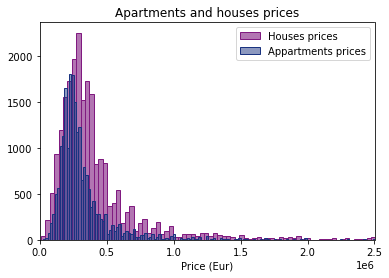

In [7]:
plt.hist(houses["Prix"],bins = 300, color = (0.5,0.1,0.5,0.6),edgecolor = (0.5,0.1,0.5,1), label="Houses prices")
plt.hist(apartments["Prix"], bins = 300, color=(0.1, 0.2, 0.5, 0.5),edgecolor = (0.1, 0.2, 0.5, 1), label="Appartments prices")
plt.xlim([0,2500000])
plt.title("Apartments and houses prices")
plt.xlabel("Price (Eur)")
plt.legend(loc='upper right')
plt.show()

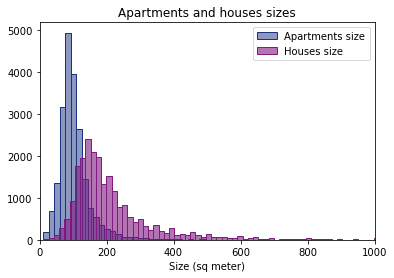

In [8]:
plt.hist(apartments["Surface habitable"], bins = 300, color=(0.1, 0.2, 0.5, 0.5),edgecolor = (0.1, 0.2, 0.5, 1), label= "Apartments size")
plt.hist(houses["Surface habitable"], bins = 300, color = (0.5,0.1,0.5,0.6),edgecolor = (0.5,0.1,0.5,1), label= "Houses size")
plt.xlim([0,1000])
plt.title("Apartments and houses sizes")
plt.xlabel("Size (sq meter)")
plt.legend(loc='upper right')
plt.show()

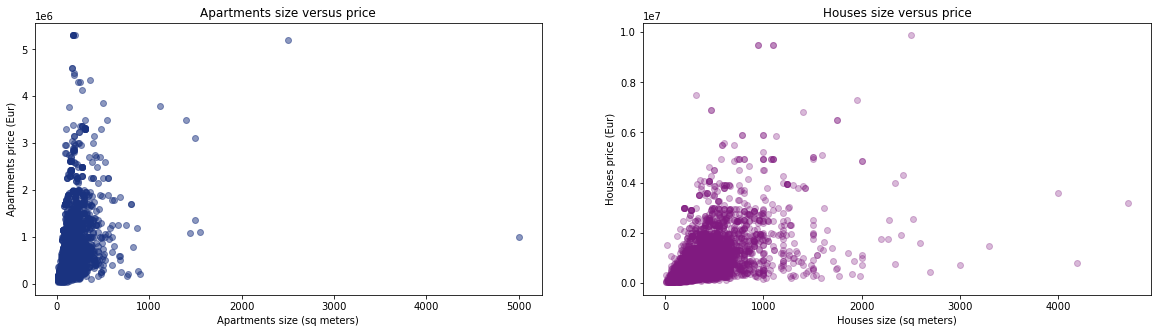

In [9]:
fig, axes = plt.subplots(1,2, figsize=(20,5))

axes[0].scatter(apartments["Surface habitable"],apartments["Prix"], color=(0.1, 0.2, 0.5, 0.5))
axes[0].set_title("Apartments size versus price")
axes[0].set_xlabel("Apartments size (sq meters)")
axes[0].set_ylabel("Apartments price (Eur)")

axes[1].scatter(houses["Surface habitable"],houses["Prix"], color=(0.5,0.1,0.5,0.3))
axes[1].set_title("Houses size versus price")
axes[1].set_xlabel("Houses size (sq meters)")
axes[1].set_ylabel("Houses price (Eur)")

plt.show()

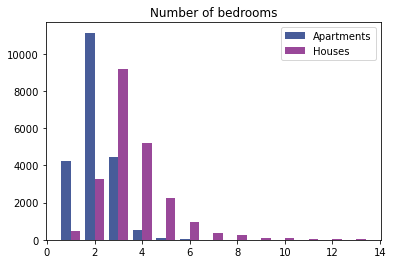

In [10]:
plt.hist([apartments["Chambres"], houses["Chambres"]], bins=(range(1,15)), align="left", label=['Apartments', 'Houses'], color=[(0.1, 0.2, 0.5, 0.8),(0.5,0.1,0.5,0.8)])
plt.title("Number of bedrooms")
plt.legend(loc='upper right')         
plt.show()

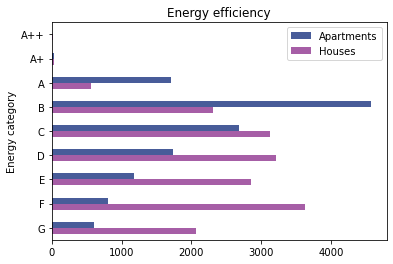

In [130]:
classe_ener_apart = apartments.groupby(['Classe énergétique']).count()
classe_ener_apart = pd.DataFrame({"Energy category":['A++','A+','A','B','C','D','E','F','G'],
                            "Apartments": classe_ener_apart["Identifiant"]})

classe_ener_houses = houses.groupby(['Classe énergétique']).count()
classe_ener_houses = pd.DataFrame({"Energy category":['A++','A+','A','B','C','D','E','F','G'],
                            "Houses": classe_ener_houses["Identifiant"]})

classe_ener = classe_ener_apart.merge(classe_ener_houses, on="Energy category")
classe_ener = classe_ener.set_index("Energy category")

classe_ener.plot.barh(title="Energy efficiency",
             color=[(0.1, 0.2, 0.5, 0.8),(0.5,0.1,0.5,0.7)])
plt.legend(loc='upper right')
plt.gca().invert_yaxis()
plt.show()


## Apartments price analysis

In [13]:
# variables for the analysis of the price for apartments
apt_vars = apartments[["Prix",
                        "Surface habitable",
                        "Chambres",
                        "Type de cuisine",
                        "Salles de bains",
                        "Toilettes",
                        "Terrasse",
                        "Jardin",
                        "Parking",
                        "Étage",
                        "État du bâtiment",
                        "Classe énergétique",
                        "Revenu moyen",
                        "Pop densité (km2)",
                        "Degré d'urbanisation",
                        "Bxl",
                        "Knokke",
                        "Prix median 2020 appartements",
                        "Refnis"
                      ]]

### OLS / linear regression

In [14]:
# run OLS algorithm and show summary

algo = "OLS"
knokke_excl = False
df = apt_vars

x_data, y_data, feature_names = load_data(df, algo, knokke_excl)
model, y_pred, r2 = OLS_regression(x_data, y_data)
model.summary()


<ipython-input-6-e22f4f556d46>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace = True)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Prix   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     495.6
Date:                Thu, 18 Nov 2021   Prob (F-statistic):               0.00
Time:                        17:57:45   Log-Likelihood:                -57981.
No. Observations:                4270   AIC:                         1.160e+05
Df Residuals:                    4251   BIC:                         1.161e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                         -1.891e+05   3.02e+04     -6.261      0.000   -2.48e+05    -1.3e+05
Surface habitable              3581.8638    103.106     34.740      0.000    3379.722    3784.005
Chambres                      -4.865e+04   5274.731     -9.223      0.000    -5.9e+04   -3.83e+04
Type de cuisine               -1.837e+04   4589.598     -4.002      0.000   -2.74e+04   -9369.637
Salles de bains                1.143e+05   8220.057     13.905      0.000    9.82e+04     1.3e+05
Toilettes                      3.769e+04   6647.465      5.669      0.000    2.47e+04    5.07e+04
Terrasse                       1.202e+04   6943.822      1.731      0.084   -1593.030    2.56e+04
Jardin                         9295.8961   1.31e+04      0.709      0.478   -1.64e+04     3.5e+04
Parking                        2422.1600   6356.365      0.381      0.703      -1e+04    1.49e+04
Étage                          7162.8331   1034.778      6.922      0.000    5134.128    9191.538
État du bâtiment              -1.947e+04   3030.620     -6.424      0.000   -2.54e+04   -1.35e+04
Classe énergétique            -1.173e+04   2283.791     -5.134      0.000   -1.62e+04   -7248.683
Revenu moyen                     -2.7133      1.123     -2.417      0.016      -4.915      -0.512
Pop densité (km2)                 0.3525      1.090      0.323      0.746      -1.784       2.489
Degré d'urbanisation          -2.028e+04   8822.159     -2.299      0.022   -3.76e+04   -2988.248
Bxl                           -1.643e+04    1.3e+04     -1.262      0.207    -4.2e+04    9089.547
Knokke                         2.706e+05   2.53e+04     10.713      0.000    2.21e+05     3.2e+05
Prix median 2020 appartements     1.3042      0.103     12.603      0.000       1.101       1.507
Refnis                            0.0666      0.196      0.341      0.733      -0.317       0.450
==============================================================================
Omnibus:                     3942.770   Durbin-Watson:                   1.316
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           293434.318
Skew:                           4.168   Prob(JB):                         0.00
Kurtosis:                      42.747   Cond. No.                     2.59e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.59e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

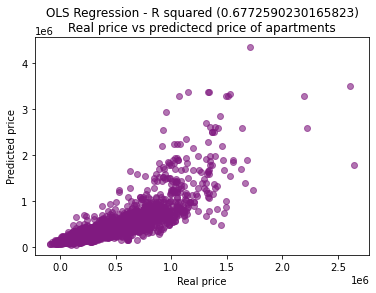

In [15]:
# plot predictions versus real price per square meter

plt.scatter(y_pred, y_data, color = (0.5,0.1,0.5,0.6))
plt.title("OLS Regression - R squared ({})\nReal price vs predictecd price of apartments".format(r2))
plt.xlabel("Real price")
plt.ylabel("Predicted price")
plt.show()

### Random forest regression

In [16]:
# run random forest algorithm

algo = "RFR"
knokke_excl = False
df = apt_vars
x_data, y_data, feature_names = load_data(df, algo, knokke_excl)
y_test_apt, y_pred_apt, r2_apt, model_RFR_apt = forest_regression(x_data, y_data) 

<ipython-input-6-e22f4f556d46>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace = True)


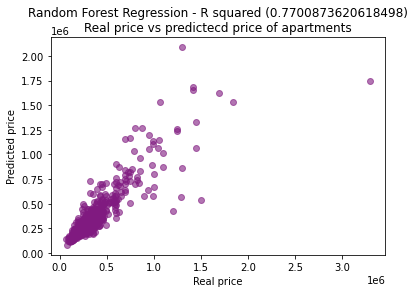

In [17]:
# plot predictions versus real price per square meter
plt.scatter(y_test_apt, y_pred_apt, color = (0.5,0.1,0.5,0.6))
plt.title("Random Forest Regression - R squared ({})\nReal price vs predictecd price of apartments".format(r2_apt))
plt.xlabel("Real price")
plt.ylabel("Predicted price")
plt.show()

In [18]:
# list feature importances of the random forest predictions

features_importance_apt = model_RFR_apt.feature_importances_
print("Feature ranking:")
for i, data_class in enumerate(feature_names):
    print("{}. {} ({})".format(i + 1, data_class, features_importance_apt[i]))
print(sum(features_importance_apt))

Feature ranking:
1. Surface habitable (0.3608825640954241)
2. Chambres (0.018495751462702083)
3. Type de cuisine (0.014057404627119154)
4. Salles de bains (0.1840661594980578)
5. Toilettes (0.06674572374639541)
6. Terrasse (0.0029931690018642266)
7. Jardin (0.004752408666706972)
8. Parking (0.0043287194558409466)
9. Étage (0.0673075523615881)
10. État du bâtiment (0.021920391877006683)
11. Classe énergétique (0.03682098846590326)
12. Revenu moyen (0.010982126094553957)
13. Pop densité (km2) (0.012142047329148956)
14. Degré d'urbanisation (0.002610415957118097)
15. Bxl (0.002095683748062663)
16. Knokke (0.031221355113260924)
17. Prix median 2020 appartements (0.1424816607146373)
18. Refnis (0.016095877784609414)
1.0


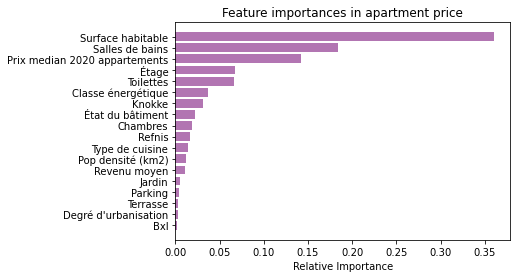

In [19]:
features = feature_names
importances = model_RFR_apt.feature_importances_
indices = np.argsort(importances)

plt.title('Feature importances in apartment price')
plt.barh(range(len(indices)), importances[indices], color = (0.5,0.1,0.5,0.6), align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Houses price analysis

In [20]:
# variables for the analysis of the price for houses

houses_vars = houses[["Prix",
                      "Surface du terrain",
                      "Surface habitable",
                      "Chambres",
                      "Type de cuisine",
                      "Salles de bains",
                      "Toilettes",
                      "Terrasse",
                      "Jardin",
                      "Nombre de façades",
                      "État du bâtiment",
                      "Classe énergétique",
                      "Revenu moyen",
                      "Pop densité (km2)",
                      "Degré d'urbanisation",
                      "Bxl",
                      "Knokke",
                      "Prix median 2020 maisons",
                      "Refnis"
                     ]]

#### OLS / Linear regression

In [21]:
# run OLS algorithm and show summary

algo = "OLS"
knokke_excl = False
df = houses_vars
x_data, y_data, feature_names = load_data(df, algo, knokke_excl)
model, y_pred, r2 = OLS_regression(x_data, y_data)
model.summary()

<ipython-input-6-e22f4f556d46>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace = True)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Prix   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     700.9
Date:                Thu, 18 Nov 2021   Prob (F-statistic):               0.00
Time:                        17:58:03   Log-Likelihood:                -94700.
No. Observations:                6780   AIC:                         1.894e+05
Df Residuals:                    6761   BIC:                         1.896e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                    -2.243e+05    3.7e+04     -6.056      0.000   -2.97e+05   -1.52e+05
Surface du terrain           0.0030      0.002      1.904      0.057   -8.99e-05       0.006
Surface habitable         1370.3495     33.800     40.543      0.000    1304.091    1436.608
Chambres                 -1.384e+04   3291.806     -4.204      0.000   -2.03e+04   -7386.980
Type de cuisine          -1.132e+04   5125.718     -2.209      0.027   -2.14e+04   -1276.804
Salles de bains           9.897e+04   5541.368     17.860      0.000    8.81e+04     1.1e+05
Toilettes                 2.574e+04   4404.605      5.844      0.000    1.71e+04    3.44e+04
Terrasse                  1.148e+04   7713.281      1.489      0.137   -3639.025    2.66e+04
Jardin                    2266.0619   7043.843      0.322      0.748   -1.15e+04    1.61e+04
Nombre de façades           6.8e+04   4577.955     14.853      0.000     5.9e+04     7.7e+04
État du bâtiment         -3.835e+04   3529.695    -10.866      0.000   -4.53e+04   -3.14e+04
Classe énergétique       -1449.7754   2582.776     -0.561      0.575   -6512.830    3613.280
Revenu moyen                -2.3469      1.326     -1.770      0.077      -4.945       0.252
Pop densité (km2)          -12.0423      2.786     -4.322      0.000     -17.504      -6.581
Degré d'urbanisation     -5.346e+04   7348.415     -7.275      0.000   -6.79e+04   -3.91e+04
Bxl                       1.133e+05   2.86e+04      3.965      0.000    5.73e+04    1.69e+05
Knokke                    4.356e+05   5.48e+04      7.955      0.000    3.28e+05    5.43e+05
Prix median 2020 maisons     1.3438      0.076     17.718      0.000       1.195       1.492
Refnis                      -0.4171      0.194     -2.147      0.032      -0.798      -0.036
==============================================================================
Omnibus:                     8664.663   Durbin-Watson:                   1.728
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4859718.603
Skew:                           6.569   Prob(JB):                         0.00
Kurtosis:                     133.499   Cond. No.                     3.50e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.5e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

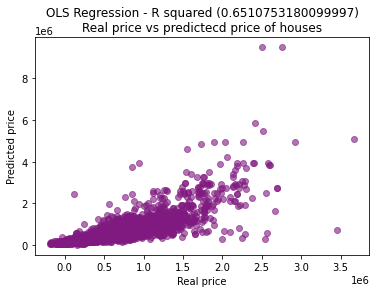

In [22]:
# plot predictions versus real price per square meter

plt.scatter(y_pred, y_data, color = (0.5,0.1,0.5,0.6))
plt.title("OLS Regression - R squared ({})\nReal price vs predictecd price of houses".format(r2))
plt.xlabel("Real price")
plt.ylabel("Predicted price")
plt.show()

 #### Random Forest Regression

In [23]:
# run random forest algorithm

algo = "RFR"
knokke_excl = False
df = houses_vars
x_data, y_data, feature_names = load_data(df, algo, knokke_excl)
y_test, y_pred, r2, model_RFR_houses = forest_regression(x_data, y_data) 

<ipython-input-6-e22f4f556d46>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace = True)


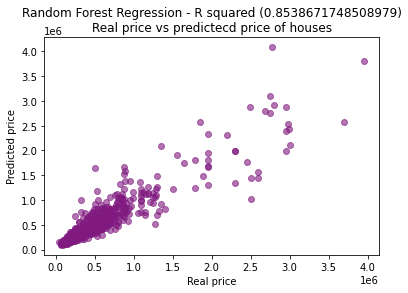

In [24]:
# plot predictions versus real price per square meter

plt.scatter(y_test, y_pred, color = (0.5,0.1,0.5,0.6))
plt.title("Random Forest Regression - R squared ({})\nReal price vs predictecd price of houses".format(r2))
plt.xlabel("Real price")
plt.ylabel("Predicted price")
plt.show()

In [25]:
# list feature importances of the random forest predictions

features_importance = model_RFR_houses.feature_importances_
print("Feature ranking:")
for i, data_class in enumerate(feature_names):
    print("{}. {} ({})".format(i + 1, data_class, features_importance[i]))
print(sum(features_importance))

Feature ranking:
1. Surface du terrain (0.12944332498907907)
2. Surface habitable (0.4723575593819672)
3. Chambres (0.010135233652700996)
4. Type de cuisine (0.008748247730980263)
5. Salles de bains (0.024754790965117925)
6. Toilettes (0.03295699674522481)
7. Terrasse (0.0026459455840170155)
8. Jardin (0.0026945931108992324)
9. Nombre de façades (0.005010287180990693)
10. État du bâtiment (0.013676025294011542)
11. Classe énergétique (0.016127152406004198)
12. Revenu moyen (0.011249507133151222)
13. Pop densité (km2) (0.017961676776179818)
14. Degré d'urbanisation (0.0023401322298838506)
15. Bxl (0.0005579034930429162)
16. Knokke (0.0036983334557270566)
17. Prix median 2020 maisons (0.22569163286728208)
18. Refnis (0.01995065700374014)
0.9999999999999999


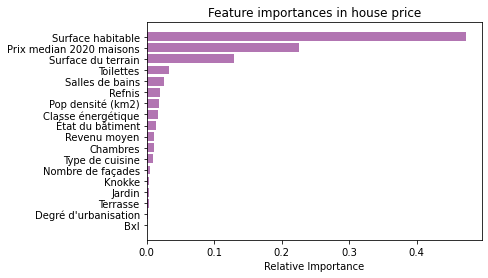

In [26]:
features = feature_names
importances = model_RFR_houses.feature_importances_
indices = np.argsort(importances)

plt.title('Feature importances in house price')
plt.barh(range(len(indices)), importances[indices], color = (0.5,0.1,0.5,0.6), align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## All properties listed (houses + apartments)

In [27]:
# variables for the analysis of the price for all properties

prop_vars = properties[["Prix",
                        "Surface habitable",
                        "Chambres",
                        "Type de cuisine",
                        "Salles de bains",
                        "Toilettes",
                        "Terrasse",
                        "Jardin",
                        "Parking",
                        "État du bâtiment",
                        "Classe énergétique",
                        "Revenu moyen",
                        "Pop densité (km2)",
                        "Degré d'urbanisation",
                        "Bxl",
                        "Knokke",
                        "Prix median 2020 appartements",
                        "Prix median 2020 maisons",
                        "Refnis"
                       ]]

### OLS regerssion

In [28]:
# run OLS algorithm and show summary

algo = "OLS"
knokke_excl = False
df = prop_vars
x_data, y_data, feature_names = load_data(df, algo, knokke_excl)
model, y_pred, r2 = OLS_regression(x_data, y_data)
model.summary()

<ipython-input-6-e22f4f556d46>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace = True)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Prix   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     918.8
Date:                Thu, 18 Nov 2021   Prob (F-statistic):               0.00
Time:                        17:58:34   Log-Likelihood:            -1.5661e+05
No. Observations:               11227   AIC:                         3.133e+05
Df Residuals:                   11208   BIC:                         3.134e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                         -6.807e+04   2.73e+04     -2.490      0.013   -1.22e+05   -1.45e+04
Surface habitable              1495.3833     31.201     47.927      0.000    1434.223    1556.544
Chambres                       2127.2857   2804.311      0.759      0.448   -3369.657    7624.229
Type de cuisine                -2.16e+04   4031.207     -5.358      0.000   -2.95e+04   -1.37e+04
Salles de bains                2.216e+04   2232.590      9.927      0.000    1.78e+04    2.65e+04
Toilettes                      8.343e+04   3571.399     23.360      0.000    7.64e+04    9.04e+04
Terrasse                       1.679e+04   5833.783      2.879      0.004    5359.670    2.82e+04
Jardin                        -5672.8473   6017.525     -0.943      0.346   -1.75e+04    6122.559
Parking                        4.992e+04   5598.171      8.916      0.000    3.89e+04    6.09e+04
État du bâtiment              -3.204e+04   2659.407    -12.046      0.000   -3.72e+04   -2.68e+04
Classe énergétique            -7154.1407   1900.141     -3.765      0.000   -1.09e+04   -3429.531
Revenu moyen                     -1.9680      1.062     -1.853      0.064      -4.050       0.114
Pop densité (km2)                -4.2004      1.264     -3.324      0.001      -6.678      -1.723
Degré d'urbanisation          -3.988e+04   7155.493     -5.573      0.000   -5.39e+04   -2.58e+04
Bxl                           -2.815e+04    1.5e+04     -1.878      0.060   -5.75e+04    1232.910
Knokke                         3.006e+05   2.53e+04     11.892      0.000    2.51e+05     3.5e+05
Prix median 2020 appartements     0.1439      0.125      1.150      0.250      -0.101       0.389
Prix median 2020 maisons          0.9629      0.061     15.849      0.000       0.844       1.082
Refnis                           -0.3774      0.156     -2.417      0.016      -0.683      -0.071
==============================================================================
Omnibus:                    12713.507   Durbin-Watson:                   1.524
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6458575.010
Skew:                           5.234   Prob(JB):                         0.00
Kurtosis:                     120.034   Cond. No.                     4.34e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.34e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

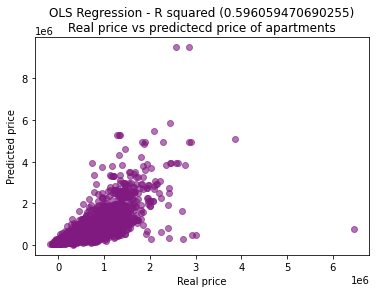

In [29]:
# plot predictions versus real price per square meter

plt.scatter(y_pred, y_data, color = (0.5,0.1,0.5,0.6))
plt.title("OLS Regression - R squared ({})\nReal price vs predictecd price of apartments".format(r2))
plt.xlabel("Real price")
plt.ylabel("Predicted price")
plt.show()

### Random Forest Regression

In [30]:
# run random forest algorithm
algo = "RFR"
knokke_excl = False
df = prop_vars
x_data, y_data, feature_names = load_data(df, algo, knokke_excl)
y_test, y_pred, r2, model_RFR_all = forest_regression(x_data, y_data) 

<ipython-input-6-e22f4f556d46>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace = True)


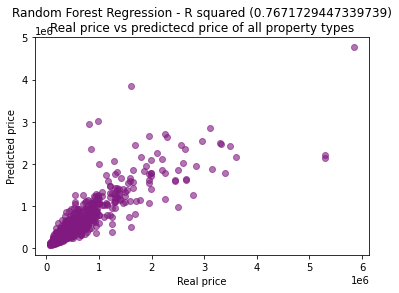

In [31]:
# plot predictions versus real price per square meter

plt.scatter(y_test, y_pred, color = (0.5,0.1,0.5,0.6))
plt.title("Random Forest Regression - R squared ({})\nReal price vs predictecd price of all property types".format(r2))
plt.xlabel("Real price")
plt.ylabel("Predicted price")
plt.show()

In [32]:
# list feature importances of the random forest predictions

features_importance = model_RFR_all.feature_importances_
print("Feature ranking:")
for i, data_class in enumerate(feature_names):
    print("{}. {} ({})".format(i + 1, data_class, features_importance[i]))
print(sum(features_importance))

Feature ranking:
1. Surface habitable (0.4346448657368776)
2. Chambres (0.024083637570456035)
3. Type de cuisine (0.011946336911521927)
4. Salles de bains (0.11450039021516208)
5. Toilettes (0.05014206186405865)
6. Terrasse (0.003452776680883352)
7. Jardin (0.005840548531346454)
8. Parking (0.006185654018338504)
9. État du bâtiment (0.024067644053611673)
10. Classe énergétique (0.03033204508244559)
11. Revenu moyen (0.017830846403422727)
12. Pop densité (km2) (0.020649451161775387)
13. Degré d'urbanisation (0.003426160391342207)
14. Bxl (0.0019747342650624257)
15. Knokke (0.0020723095607121616)
16. Prix median 2020 appartements (0.03367735229083197)
17. Prix median 2020 maisons (0.1972367860146497)
18. Refnis (0.017936399247501594)
1.0000000000000002


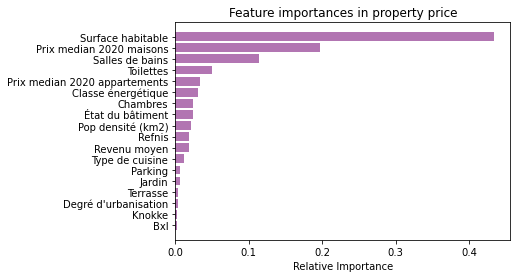

In [33]:
features = feature_names
importances = model_RFR_all.feature_importances_
indices = np.argsort(importances)

plt.title('Feature importances in property price')
plt.barh(range(len(indices)), importances[indices], color = (0.5,0.1,0.5,0.6), align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()